In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import findspark
findspark.init() 

import pyspark
sc = pyspark.SparkContext()

In [4]:
from mnist import MNIST
mndata = MNIST('/Volumes/TRANSCEND/MNIST/python-mnist/data')
images, labels = mndata.load_training()

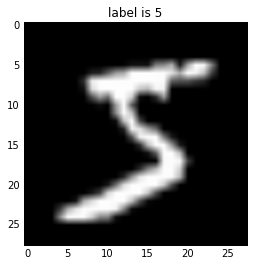

In [18]:
iimage = np.array(images[0], dtype='uint8')

plt.imshow(iimage.reshape(28,28), cmap='gray')
plt.title('label is ' + str(labels[0]))
plt.show()

In [35]:
#Build feature map
N = 500 #How many images I want to load
d = 784 #Pixels of MNIST data

#Choose which label you want to train
label_choose = 4


feature_map = np.zeros((N,d))
ydat = []
for i in range(N): #Just do a subset of training for now
    is_label = 1*(labels[i] == label_choose)
    ydat.append(is_label)
    feature_map[i,:] = images[i]


In [32]:

lambda_grid = [1e-4, 1e-3, 1e-2, 0, 10, 1e2]


In [37]:
dpoints = zip(ydat, feature_map)

#Start spark instance on points
points = sc.parallelize(dpoints)

#First use Spark to center the image - removes bias
x_mean = points.map(lambda x: x[1]).reduce(lambda x,y: (x+y) ) / float(N)
y_mean = np.mean(ydat)

x_c = points.map(lambda x: x[1] - x_mean).take(N)
y_c = [iy - y_mean for iy in ydat]

#Start spark instance on centered points
cpoints = sc.parallelize(zip(y_c, x_c))


In [41]:
#Analytical solution to problem

#Do numerator first - doesn't require regularization
numer_map = cpoints.map(lambda x:x[1] * (x[0])) 
numer_sum = numer_map.reduce(lambda x,y: x+y)

#Do denominator over lambda grid
#Get analytical solution with associated error
w_stars = []
w_error = []
for ll in lambda_grid:
    denom_map = cpoints.map(lambda x: np.dot(x[1], x[1].T) + N*ll) #Need to add regularization - lambda
    denom_sum = denom_map.reduce(lambda x,y: x+y)
    iw = numer_sum / float(denom_sum)
    
    iout = np.dot(x_c, iw)
    iclass = [0 if q < 0 else 1 for q in iout]
    
    ierr = np.sum([ic == il for ic,il in zip(iclass, ydat)]) / float(N)
    
    w_stars.append(iw)
    w_error.append(ierr)
    
#Choose best solution
w_star = w_stars[np.where(w_error == np.min(w_error))[0][0]]


In [43]:
best_pred = np.dot(x_c, w_star)
best_class = [0 if q < 0 else 1 for q in iout]
accur = np.sum([ic == il for ic,il in zip(best_class, ydat)]) / float(N)

accur

0.65400000000000003

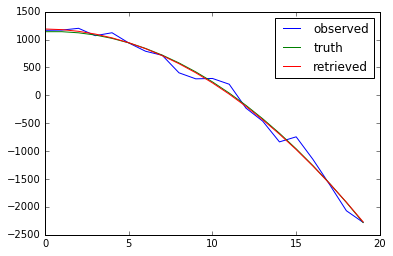

In [342]:
#Visualize Result
plt.plot(xdat, y_c, label='observed')
plt.plot(xdat, [iy - np.mean(y) for iy in y], label='truth')
plt.plot(np.dot(x_c, w_star), label='retrieved')
plt.legend()
plt.show()
